In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Data loading

In [35]:
# Data loading
path = r'../data/processed/data_processed_v3_National_NoAcum_Total.csv'
alzheimer_df = pd.read_csv(path)

print(alzheimer_df.info())
alzheimer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       572 non-null    int64  
 1   Week       572 non-null    int64  
 2   Date       572 non-null    object 
 3   Epi_Year   572 non-null    int64  
 4   New_Cases  572 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 22.5+ KB
None


,Year,Week,Date,Epi_Year,New_Cases
0,2014,2,2014-01-06,2014,9.8125
1,2014,3,2014-01-13,2014,29.0000
2,2014,4,2014-01-20,2014,47.0000
3,2014,5,2014-01-27,2014,35.5000
4,2014,6,2014-02-03,2014,40.5000


### Prepare data for Prophet

In [36]:
alzheimer_df['Date'] = pd.to_datetime(alzheimer_df['Date'])

alzheimer_df.drop(columns=['Year', 'Week', 'Epi_Year'], inplace=True)
alzheimer_df.rename(columns={'Date': 'ds', 'New_Cases': 'y'}, inplace=True)

alzheimer_df.info()
alzheimer_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      572 non-null    datetime64[ns]
 1   y       572 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.1 KB


,ds,y
567,2024-11-25,29.0
568,2024-12-02,47.5
569,2024-12-09,43.5
570,2024-12-16,30.0
571,2024-12-23,37.0


### New Data loading (2025) and concat

In [37]:
# Data loading
path = r'../data/processed/nuevos_datos.csv'
nuevos_df = pd.read_csv(path)
nuevos_df['ds'] = pd.to_datetime(nuevos_df['ds'])

print(nuevos_df.info())
nuevos_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      43 non-null     datetime64[ns]
 1   y       43 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 820.0 bytes
None


,ds,y
0,2024-12-30,25
1,2025-01-06,23
2,2025-01-13,35
3,2025-01-20,38
4,2025-01-27,40


In [38]:
df_2025 = pd.concat([alzheimer_df, nuevos_df], ignore_index=False)
df_2025.info()
df_2025.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 42
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      615 non-null    datetime64[ns]
 1   y       615 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.4 KB


,ds,y
38,2025-09-22,26.0
39,2025-09-29,37.0
40,2025-10-06,34.0
41,2025-10-13,49.0
42,2025-10-20,45.0


# Graph Time Series Decomposition - New Cases (Weekly Data)

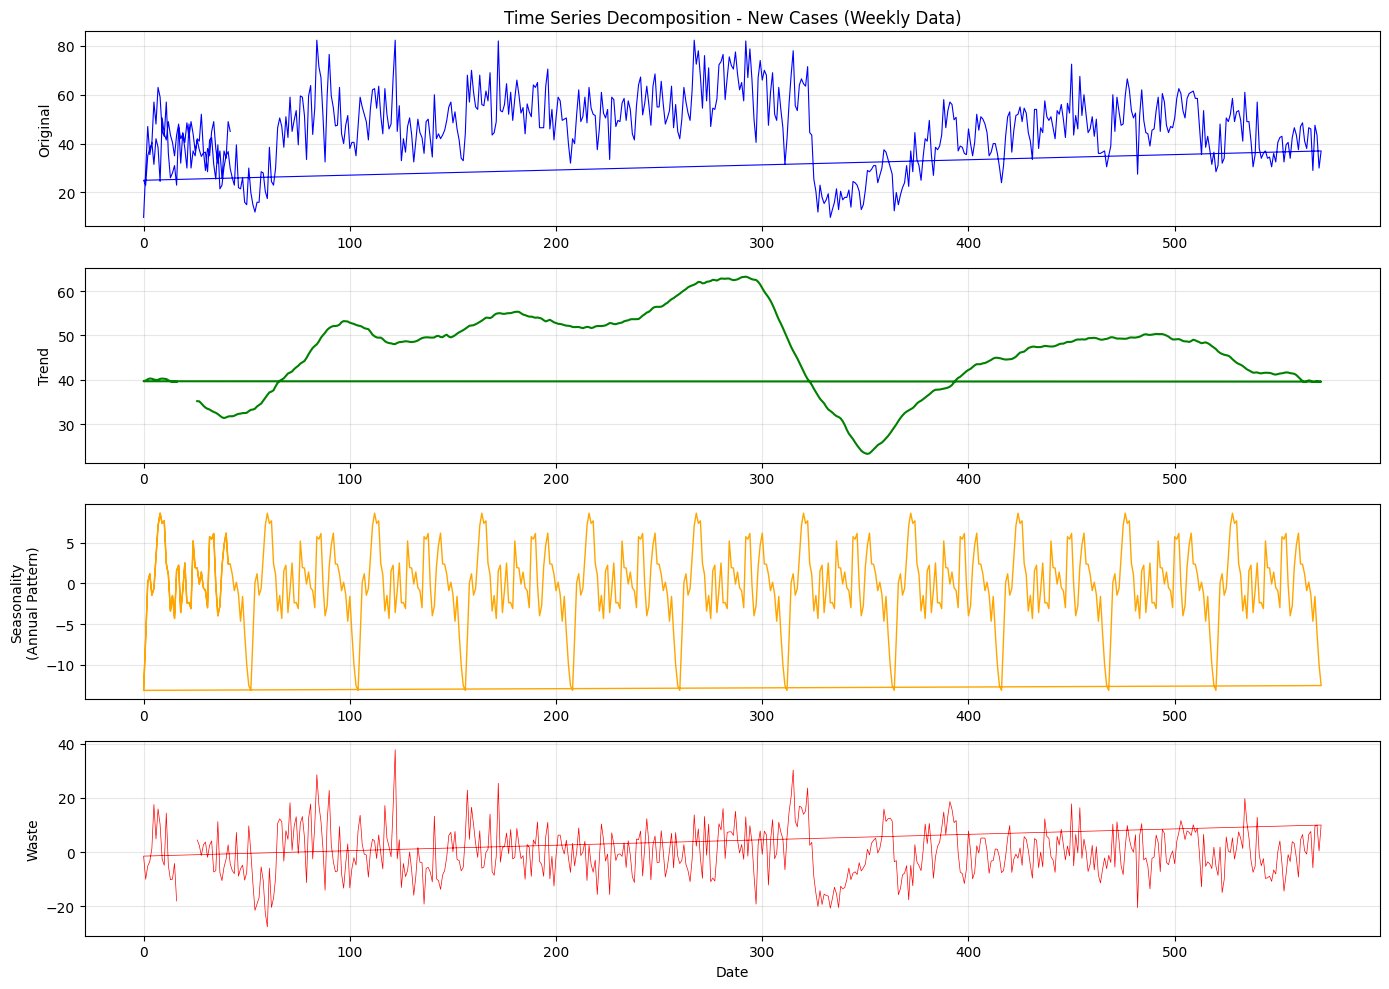

In [39]:
# Decomposition with period=52 (annual seasonality)
decomposition = seasonal_decompose(df_2025['y'], 
                                   model='additive',
                                   period=52)

# Graph
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

axes[0].plot(df_2025['y'], color='blue', linewidth=0.8)
axes[0].set_ylabel('Original')
axes[0].set_title('Time Series Decomposition - New Cases (Weekly Data)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition.trend, color='green', linewidth=1.5)
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition.seasonal, color='orange', linewidth=1)
axes[2].set_ylabel('Seasonality\n(Annual Pattern)')
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition.resid, color='red', linewidth=0.5)
axes[3].set_ylabel('Waste')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ensemble Prophet + XGBoost

Train: 468 weeks | Test: 95 weeks

🔄 Training Prophet...


19:39:03 - cmdstanpy - INFO - Chain [1] start processing
19:39:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet trained

🔄 Training XGBoost...
✅ XGBoost trained

📊 COMPARATIVE RESULTS:

Prophet only:      MAPE = 13.41%  |  MAE = 5.27
XGBoost only:      MAPE = 13.43%  |  MAE = 4.90
Ensemble (60/40):  MAPE = 12.45%  |  MAE = 4.74  |  RMSE = 5.86



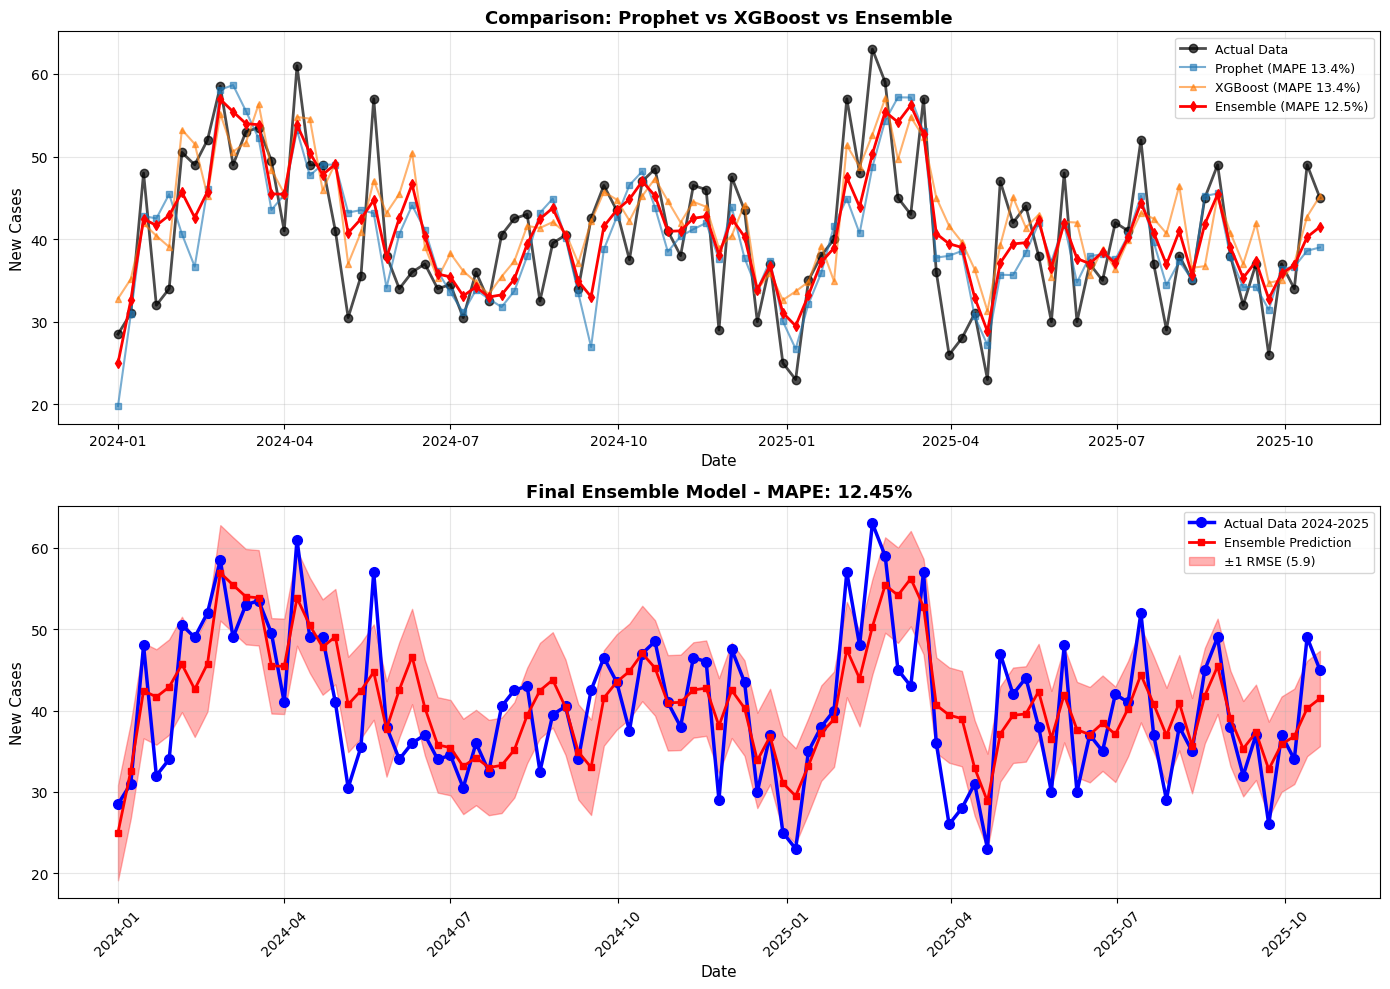

📊 TOP 5 MOST IMPORTANT FEATURES (XGBoost):
       feature  importance
rolling_mean_4    0.489994
rolling_mean_8    0.140866
         lag_1    0.103016
         lag_2    0.057854
 rolling_std_4    0.041804


In [40]:
df = df_2025.copy()

# STEP 1: Feature engineering
def create_features(df):
    df = df.copy()
    df['week_of_year'] = df['ds'].dt.isocalendar().week
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_from_start'] = (df['ds'] - df['ds'].min()).dt.days

    df['lag_1'] = df['y'].shift(1)
    df['lag_2'] = df['y'].shift(2)
    df['lag_4'] = df['y'].shift(4)
    df['lag_52'] = df['y'].shift(52)

    df['rolling_mean_4'] = df['y'].rolling(4).mean()
    df['rolling_std_4'] = df['y'].rolling(4).std()
    df['rolling_mean_8'] = df['y'].rolling(8).mean()

    return df.dropna()

df_features = create_features(df)

# STEP 2: Split using post-COVID data (more relevant)
split_date = '2024-01-01'
train_df = df_features[df_features['ds'] < split_date].copy()
test_df = df_features[df_features['ds'] >= split_date].copy()

print(f"Train: {len(train_df)} weeks | Test: {len(test_df)} weeks\n")

# STEP 3: Prophet Model (captures trend + seasonality)
covid_events = pd.DataFrame({
    'holiday': 'covid_lockdown',
    'ds': pd.to_datetime(['2020-03-23']),
    'lower_window': -4,
    'upper_window': 78,
})

model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=covid_events,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.9,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_range=0.95,
)

model_prophet.add_country_holidays('MX')
model_prophet.add_seasonality(name='monthly', period=30.5/7, fourier_order=10)

# Add regressors to Prophet model
for col in ['lag_1', 'lag_4', 'rolling_mean_4', 'rolling_std_4']:
    model_prophet.add_regressor(col)

print("🔄 Training Prophet...")
train_prophet = train_df[['ds', 'y', 'lag_1', 'lag_4', 'rolling_mean_4', 'rolling_std_4']].copy()
model_prophet.fit(train_prophet)
print("✅ Prophet trained\n")

# Prophet predictions
future_prophet = test_df[['ds', 'lag_1', 'lag_4', 'rolling_mean_4', 'rolling_std_4']].copy()
forecast_prophet = model_prophet.predict(future_prophet)
pred_prophet = forecast_prophet['yhat'].values

# STEP 4: XGBoost Model (captures volatility and non-linear patterns)
feature_cols = ['week_of_year', 'month', 'quarter', 'year', 'days_from_start',
                'lag_1', 'lag_2', 'lag_4', 'lag_52',
                'rolling_mean_4', 'rolling_std_4', 'rolling_mean_8']

X_train = train_df[feature_cols]
y_train = train_df['y']
X_test = test_df[feature_cols]
y_test = test_df['y']

print("🔄 Training XGBoost...")
model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_xgb.fit(X_train, y_train)
print("✅ XGBoost trained\n")

pred_xgb = model_xgb.predict(X_test)

# STEP 5: Ensemble (weighted combination)
weight_prophet = 0.6
weight_xgb = 0.4

pred_ensemble = weight_prophet * pred_prophet + weight_xgb * pred_xgb

# STEP 6: Evaluation
mae_prophet = mean_absolute_error(y_test, pred_prophet)
mape_prophet = mean_absolute_percentage_error(y_test, pred_prophet) * 100

mae_xgb = mean_absolute_error(y_test, pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, pred_xgb) * 100

mae_ensemble = mean_absolute_error(y_test, pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, pred_ensemble))
mape_ensemble = mean_absolute_percentage_error(y_test, pred_ensemble) * 100

print("📊 COMPARATIVE RESULTS:\n")
print(f"Prophet only:      MAPE = {mape_prophet:.2f}%  |  MAE = {mae_prophet:.2f}")
print(f"XGBoost only:      MAPE = {mape_xgb:.2f}%  |  MAE = {mae_xgb:.2f}")
print(f"Ensemble (60/40):  MAPE = {mape_ensemble:.2f}%  |  MAE = {mae_ensemble:.2f}  |  RMSE = {rmse_ensemble:.2f}\n")

# STEP 7: Comparative plots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Model comparison
axes[0].plot(test_df['ds'], y_test, 'o-', label='Actual Data', linewidth=2, markersize=6, color='black', alpha=0.7)
axes[0].plot(test_df['ds'], pred_prophet, 's-', label=f'Prophet (MAPE {mape_prophet:.1f}%)', linewidth=1.5, markersize=4, alpha=0.6)
axes[0].plot(test_df['ds'], pred_xgb, '^-', label=f'XGBoost (MAPE {mape_xgb:.1f}%)', linewidth=1.5, markersize=4, alpha=0.6)
axes[0].plot(test_df['ds'], pred_ensemble, 'd-', label=f'Ensemble (MAPE {mape_ensemble:.1f}%)', linewidth=2, markersize=5, color='red')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('New Cases', fontsize=11)
axes[0].set_title('Comparison: Prophet vs XGBoost vs Ensemble', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Focus on Ensemble
axes[1].plot(test_df['ds'], y_test, 'o-', label='Actual Data 2024-2025', linewidth=2.5, markersize=7, color='blue')
axes[1].plot(test_df['ds'], pred_ensemble, 's-', label='Ensemble Prediction', linewidth=2, markersize=5, color='red')
axes[1].fill_between(test_df['ds'], pred_ensemble - rmse_ensemble, pred_ensemble + rmse_ensemble,
                     alpha=0.3, color='red', label=f'±1 RMSE ({rmse_ensemble:.1f})')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('New Cases', fontsize=11)
axes[1].set_title(f'Final Ensemble Model - MAPE: {mape_ensemble:.2f}%', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# XGBoost Feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("📊 TOP 5 MOST IMPORTANT FEATURES (XGBoost):")
print(importance.head(5).to_string(index=False))


In [41]:
test_df.head()

,ds,y,week_of_year,month,quarter,year,days_from_start,lag_1,lag_2,lag_4,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_8
520,2024-01-01,28.5,1,1,1,2024,3647,36.5,31.5,43.0,35.0,33.500,4.242641,38.0625
521,2024-01-08,31.0,2,1,1,2024,3654,28.5,36.5,37.5,39.0,31.875,3.350995,37.5000
522,2024-01-15,48.0,3,1,1,2024,3661,31.0,28.5,31.5,60.0,36.000,8.669871,36.8125
523,2024-01-22,32.0,4,1,1,2024,3668,48.0,31.0,36.5,45.0,34.875,8.872946,36.0000
524,2024-01-29,34.0,5,1,1,2024,3675,32.0,48.0,28.5,59.0,36.250,7.932003,34.8750
